In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../")

In [2]:
import pickle as pk
import numpy as np

from steric_free_simulator import Optimizer
from steric_free_simulator import ReactionNetwork

/home/spencerloggia/Projects/biphy/multi_assembly/steric_free_simulator/energy_space_explorer.py:8: UserWarning: Import of 'rosetta' as a top-level module is deprecated and may be removed in 2018, import via 'pyrosetta.rosetta'.
  from rosetta.protocols.relax import *


In [3]:
from steric_free_simulator import EnergyExplorer

Define the AP2 Network from scratch. We will build the one step network.

In [5]:
base_input = './input_files/ap2.bngl'
rn = ReactionNetwork(base_input, one_step=True)

KeyError: -1

Create an EnergyExplorer object to define the Rxn Energies on each edge. If relaxed poses are already defined in the subunit dir, will load them instead of recalculating. Otherwise will build all pdb states from monomer pdb files. Raw PDB names must match monomer labels in the reaction network.

In [ ]:
subunit_dir = './pdbs/AP2_subunits'
en = EnergyExplorer(rn, subunit_dir)
en.explore_network()

# Dump the explored network to pickle binary for easy reuse.
unoptimized_save_loc = './local_saves/ap2_en_net_vivo.pkl'
with open(unoptimized_save_loc, 'wb') as f:
    pk.dump(rn, f)

Can skip the above two steps if load existing explore network pickle.


In [18]:
unoptimized_save_loc = './local_saves/ap2_en_net_vivo.pkl'
with open(unoptimized_save_loc, 'rb') as f:
    rn = pk.load(f)

Initialize parameters to equal in the reaction network, and add them to the hash map tracking optimization parameters.

In [19]:
rn.reset()
rn.intialize_activations()
print(rn._initial_copies)

{0: tensor([447.], dtype=torch.float64), 1: tensor([606.], dtype=torch.float64), 2: tensor([585.], dtype=torch.float64), 3: tensor([845.], dtype=torch.float64), 4: tensor([0.], dtype=torch.float64), 5: tensor([0.], dtype=torch.float64), 6: tensor([0.], dtype=torch.float64), 7: tensor([0.], dtype=torch.float64), 8: tensor([0.], dtype=torch.float64), 9: tensor([0.], dtype=torch.float64), 10: tensor([0.], dtype=torch.float64), 11: tensor([0.], dtype=torch.float64), 12: tensor([0.], dtype=torch.float64), 13: tensor([0.], dtype=torch.float64), 14: tensor([0.], dtype=torch.float64)}


Create an optimizer object to run many simulations on the energy defined reaction network, tuning association parameters at each iteration.

Using the device parameter, we can choose which cpu or gpu to run the simulations and optimization with. For networks with less than about 100 possible reactions, runtime will likely be faster on a cpu.

User Defined Parameters:

- **sim_runtime**: time (in seconds) that the simulation will run for.
- **optim_iterations**: number of simlations to run, optimizing parameters at each one.
- **learning rate**: factor to multiply calculated gradients by.
- **score_constant**: A coefficient applied to each rosetta calculated score, can be thought of a converting rosseta units to Joules. Since we have no idea what this really should be, it should be set to make $\Delta G$ for each reaction realistic.
- **freq_factor**: pre-exponential factor when calculating rate constants, physically a measure of the frequency of collisions between molecules.
- **volume**: The volume of each simulation, used when calculating concentraions from copy numbers
- **device**: The hardware device to run simulations and optimizations on.

_Scroll past all of this optimization output to get to the plots_

In [20]:
optim = Optimizer(reaction_network=rn,
                  sim_runtime=.1,
                  optim_iterations=200,
                  learning_rate=.01,
                  score_constant=.01,
                  device='cpu')
optim.optimize()

Using CPU
Using CPU
yield on sim iteration 0 was 46.9%
current params: tensor([1.0100, 1.0100, 0.9900, 0.9900, 1.0100, 1.0100, 0.9900, 1.0100, 1.0100,
        0.9900, 0.9900, 1.0100, 0.9900, 0.9900, 0.9900, 1.0100, 1.0100, 1.0100,
        1.0100, 1.0100, 0.9900, 0.9900, 0.9900, 1.0100, 1.0100],
       dtype=torch.float64)
Using CPU
yield on sim iteration 1 was 47.0%
current params: tensor([1.0200, 1.0200, 0.9800, 0.9800, 1.0200, 1.0200, 0.9800, 1.0200, 1.0200,
        0.9800, 0.9800, 1.0200, 0.9800, 0.9800, 0.9800, 1.0200, 1.0200, 1.0200,
        1.0200, 1.0200, 0.9800, 0.9800, 0.9800, 1.0200, 1.0200],
       dtype=torch.float64)
Using CPU
yield on sim iteration 2 was 47.2%
current params: tensor([1.0300, 1.0300, 0.9700, 0.9700, 1.0300, 1.0300, 0.9700, 1.0300, 1.0300,
        0.9700, 0.9700, 1.0300, 0.9700, 0.9700, 0.9700, 1.0300, 1.0300, 1.0300,
        1.0300, 1.0300, 0.9700, 0.9700, 0.9700, 1.0300, 1.0300],
       dtype=torch.float64)
Using CPU
yield on sim iteration 3 was 47.4%
cur

Save the finished optimizer in case we want to use it's data later

In [21]:
with open('./local_saves/optimizer_ap2_vivo_stablerxn.pkl', 'wb') as f:
    pk.dump(optim, f)


Load an optimizer that has already been run, make sure not to overwrite anything needed!

In [ ]:
with open('./local_saves/optimizer_ap2_vivo_stablerxn.pkl', 'rb') as f:
    optim = pk.load(f)

**Plot of Simulation before any optimization**

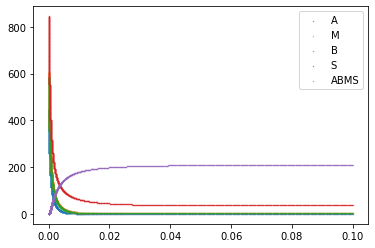

In [22]:
optim.plot_observable(iteration=0)


**Plot of Simulation after all optimization iterations**


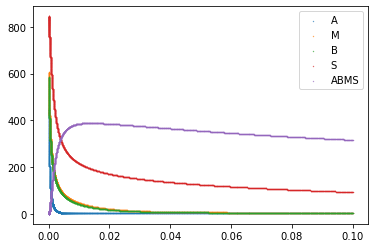

In [23]:
optim.plot_observable(iteration=-1)

**Plot of simulation yield at each optimization iteration**

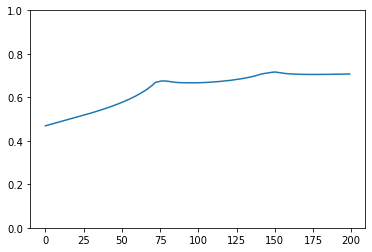

In [24]:
optim.plot_yield()

Final discovered activation energies

In [12]:
print(optim.rn.kon)


Parameter containing:
tensor([38.9622, 37.1127,  2.0700,  1.7838,  1.7107, 34.3581, 16.9147,  2.4250,
        37.6520, 18.4188,  2.1001, 32.6036,  1.7681,  1.8374,  1.8270, 26.2503,
        29.7505, 30.5779, 24.0286, 28.2227,  7.2661,  7.5065,  2.2021, 32.4703,
        17.4028], dtype=torch.float64, requires_grad=True)
